<br>
<br>

<br>

<br>


#    <center> ❄❄ Prediction of Superconducting Critical Temperature ❄❄ <center>
<br>

<img src="https://static.spektrum.de/fm/912/thumbnails/Supraleiter-schwebender-Magnet-iStock_49768936_ktsimage.jpg.3112312.jpg">

# Introduction

the goal of this notebook is modeling critical temperature of a superconductor based on its chemical properties using two regression models, Decision tree and Random forest.

The first part will tackle the theory behind the algorithms and gives a short presentation of the relative parameters and metrics.  
The second part will be reserved to the dataset preprocessing, after introducing the necessary techniques to that purpose.  
And in the last part, an evaluation of the models' performance will be presented as well as a comparative analysis to determine wich one gets to decode the pattern behind data.

<br>
<br>

> 📍📍NB: all you questions are welcome 😃😃

<br> 
<br> 
<br> 
<br> 


**What is superconductivity?**

Superconductivity is a phenomenon of exactly zero electrical resistance and expulsion of magnetic flux fields occurring in certain materials, called superconductors, when cooled below a characteristic critical temperature. Superconductors are widely used in many industries, e.g. the Magnetic Resonance Imaging (MRI) in health care, electricity transportation in energy industry and magnetic separation, etc.
Superconductivity Data Set used in this notebook is hosted in UCI machine learning [repository](https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data)   

the repository contains two files:   
* (1) train.csv contains 81 features extracted from 21263 superconductors along with the critical temperature in the 82nd column, and this will be our main dataset.
* (2) unique_m.csv contains the chemical formula broken up for all the 21263 superconductors from the train.csv file. (which we will not use)


In [1]:
#necessary import 
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sb
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve,KFold
from sklearn.preprocessing import MinMaxScaler , Normalizer
from sklearn.metrics import  explained_variance_score, mean_squared_error,mean_absolute_error
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# 1.Some mathematics
<br>

## Regression tree algorithm

A regression tree is built through a process known as binary recursive partitioning, which is an iterative process that splits the data into partitions or branches, and then continues splitting each partition into smaller groups as the method moves up each branch.

Given a training set $X_n=x_1, x_2, ... x_n$ with responses $Y_n=y_1, y_2, ... y_n$ 

Initially, the algorithm begins allocating the data into the first two partitions considering every splitting variable $j$ and split point $s$    
  
  
 <center> $ R_1(j,s) = \{ X| X_j \le s \} $ and $ R_2(j,s) = \{ X| X_j \gt s \} $ </center>
   
   
then the algorithm selects the binary split that minimizes   
  
   <center> $ [ \sum\limits_{x_i \in R_1(j,s)} (y_i-c_1)^2 + \sum\limits_{x_i \in R_2(j,s)} (y_i-c_2)^2 ]$ </center>
   
 with $c_k= avg(y_i | x_i\in R_k(j,s))$ ,  $k = 1,2$  
   
 <br>
   
   Having found the best split, This splitting rule is then applied to each of the resulting branches. This process continues until each node or partition reaches a user-prespecified minimum node size and becomes a terminal node. (If the quantity $\sum\limits_{x_i \in node} (y_i-c_{node})^2$ in a node is zero, then that node is considered a terminal node even if it has not reached the minimum size.)  
       

A very large tree might overfit the data, while a small tree might not capture the important structure. this tradeoff is governed by the tree size, and to find the best tree size, we use the cost complexity pruning algorithm:
> * start by growing a large tree $T_0$ and stop spplitting process only when minimum node size is reached.  
* for a given $\alpha$ find $T(\alpha) \subseteq T_0$ that minimize   
  
  
 <center> $ C_{\alpha}(T) = C(T) + \alpha|\tilde T|$ </center>    
   
   
>with $T$ define any subtree $\subset T_0$, and $|\tilde T|$  denote the number of terminal nodes in $T$,  and  $ C(T) =\sum\limits_{t \in \tilde T} N_t Q_t$ , $t$ indexes terminal nodes
  
  <center> $ Q_t= \frac 1{N_t} \sum\limits_{x_i \in R_t}(y_i-\hat c_t)^2 $ </center>    
   <center> $ N_t= cardinal\{x_i \in R_t\} $ </center>  
     
     
   <center> $ \hat c_t= \frac 1{N_t} \sum\limits_{x_i \in R_t}y_i $ </center>
     
> * try the above for different values of $\alpha$ and pick $\hat \alpha$ that minimizes the cross-validated error. It's clear that for $\alpha = 0$ the solution is the full tree $T_0$ and with increasing $\alpha$ the tree becomes smaller and smaller implying less complexity.

Once the final tree $T(\hat \alpha)$ is built, for every new observation that falls into a terminal node, the predicted response will be the mean value of responses in that node.

<br>
<br>

## Random forest regression algorithm

Random forest is a kind of regression trees bagging, the idea behind is to construct multiple trees at training time and averaging the results to end up with a single prediction model highly accurate.  
The conception of the algorithm is simple but requires a short explanation of each step:  
* For $b=1, ...,B$ :  

 * Sample from $X_n, Y_n$, with replacement, n-sized sample  $X_b, Y_b$ .  
 
 * for each bootsrapped training set $X_b, Y_b$, a random selection of $m$ predictors is chosen as split candidates from the full set of $p$ predictors, typically we choose $m= \sqrt p$.  
 
 * Train a regression tree $\hat T_b$ on $X_b, Y_b$.   
   
* for each new sample $x^* $, the predicted response is $ \hat y^* = \frac 1{B} \sum\limits_{b=1}^{B} \hat y^b$  
  
  
<br>
<br>

## Performance metrics
  
many performance metrics exist to evaluate the quality of fit of a regression model, The most commonly used are:

* MSE (Mean Squared Error), is defined as the average squared distance between the actual score and the predicted score, a good regression model is characterized by a small MSE and vice-versa

<center> $MSE= \frac { \sum\limits_{i=1}^n (y_i-\hat y_i)^2 }n $ </center>
<br>
* MAE (Mean Absolute Error), is the average of absolute differences between our target and predicted values,

<center> $MAE= \frac { \sum\limits_{i=1}^n |y_i-\hat y_i| }n $ </center>

<br>

the main difference between MSE and MAE is that this latter is less sensitive to outliers, how ?? ===>
Imagine a target with a spread of values in $[3,12] $ and some outliers ranging from $70$ to $100$, the squared error between 100 and 3 is huge $(100-3)^2=9409$ compared to the absolute error  $|100-3|=97$, which gives impression that the MSE is huge as well. The algorithm by trying to minimize this MSE it will gives more weights to outliers, this scenario will certainly lead to overfitted and biased model. 

So MAE loss is more preferable if we detect the existence of a outliers.

# 2. Data preprocessing

one of the most important steps in data preprocessing is feature selection which aims at reducing the dimensionality of the problem, and eliminate redundant or irrelevant (noisy) variables. Benefits are twofold: it decreases complexity of the predictive model, and allows more accurate prediction since high-dimensionality makes predictive models more prone to overfitting, and estimates of parameters more variant.   

Two are the main approaches to feature selection:
* Filter methods: They attempt to assess the merits of features from the data, ignoring the effects of the selected feature subset on the performance of the learning algorithm. Examples are methods that select variables by ranking them through compression techniques (like PCA), or by computing correlation or a more advanced similarity measure such as minimum redundancy maximum relevance (mRMR) with the output.   
* Wrapper methods: these methods assess subsets of variables according to their usefulness to a given predictor. The method conducts a search for a good subset using the learning algorithm itself as part of the evaluation function. The problem boils down to a problem of stochastic state space search. Example are the stepwise methods proposed in linear regression analysis.

## Correlation Analysis Between Predictors

after loading the training dataset we will try to investigate correlation between features, and if any features selection technique might be applied



In [2]:
import requests, io, zipfile

r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
data = pd.read_csv(z.open('train.csv'))

In [3]:
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

Except for number_of_elements and critical temperature; all of the variables are derived using highly correlated mathematical functions; mean, weighted mean, geometric mean, weighted geometric mean, standard deviation, weighted standard deviation, entropy, weighted entropy, range and weighted range calculations. This can be shown using the correlation matrix.


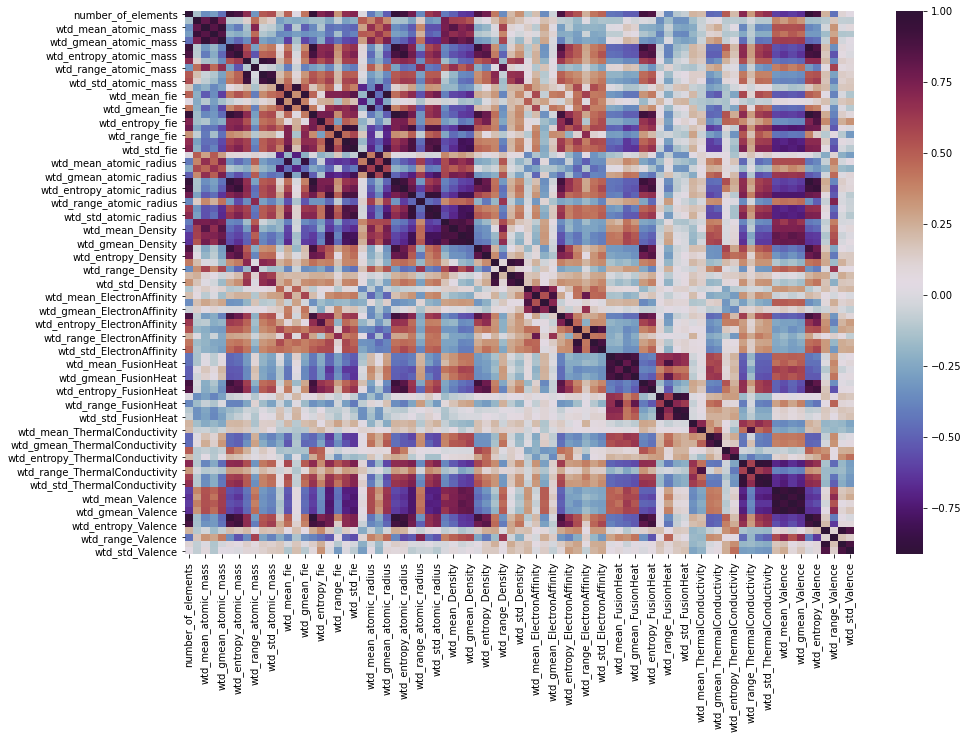

In [5]:
# display the correlation matrix
plt.figure(figsize=(15,10))
sb.heatmap(data.iloc[:,:-1].corr(),cmap='twilight_shifted')
plt.show()

Principal Component Analysis (PCA) tends to reduce the dimensions of the data. It focus  on the maximum variance amount to convert correlated variables  into a set of orthogonal - mutually uncorrelated - variables called principal components such that the first principal component accounts for the maximum proportion of the variance of the original dataset, and subsequent orthogonal components account for the maximum  proportion  of  the  remaining  variance.  The process steps of PCA are as follows:    

let $Z$ be the standardized input matrix :
 
1. Compute the mean vector of $Z$.  
2. Compute the covariance matrix of data.  
3. Compute the eigenvalue and eigenvector matrix of covariance matrix, let $E$ be the matrix of eigenvectors.
4. Sort the eigenvalues λ₁, λ₂, …, λp from largest to smallest, and then sort the eigenvectors in $E$ accordingly, let $E^*$ be the sorted matrix.
5. Form the components using $E^*$ as weighting vector. $Z^* = ZE^*$

typically we take the first components explaining at least 90% of the common variation.  

PCA technique is sensitive to the scaling of the features since it's based on the covariance matrix, a look at the summary table below shows that there are large differences between the ranges of variables in our dataset, those variables with larger ranges might dominate over those with small ranges , that is the reason why it is critical to perform standardization prior to PCA.

In [6]:
data.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,...,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987,34.421219
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,...,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580,34.254362
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,32.890369,...,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892,5.365000
50%,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,45.123500,...,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000,20.000000
75%,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,59.322812,...,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


### features scaling


In [7]:
# split  dataset into test and train
x = data.iloc[:, :-1]
y = data.iloc[:, -1] 
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.1) 

In [8]:
scalerx = MinMaxScaler()
x_train = scalerx.fit_transform(x_train)
x_test = scalerx.transform(x_test)
#scalery = MinMaxScaler()
#y_train = scalery.fit_transform(np.array(y_train).reshape(-1, 1))

### PCA application

In [9]:
pca = PCA(n_components = 30)
pca.fit(x_train)

PCA(n_components=30)

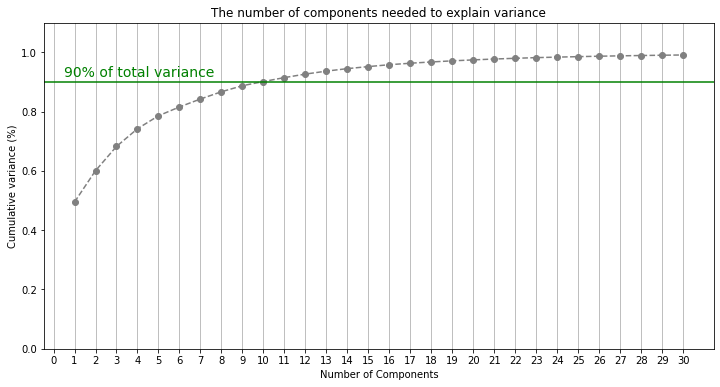

In [10]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 31, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='grey')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 31, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.9, color='g', linestyle='-')
plt.text(0.5, 0.92, '90% of total variance', color = 'g', fontsize=14)

ax.grid(axis='x')
plt.show()

This curve quantifies how much of the total 82-dimensional variance is contained within the first 30 components. As we see, the first 10 components contain 90% of the variance, 
#### one problem here is how to choose the optimal number of components ?
that's what we will try to answer using cross validation technique in the next part

# 3.Training 

In [11]:
# function returns MAE and MSE of the fitted model
# for each number of components between 1 and 20 using cross validation
def cross_validation(model,x_train,y_train):
    mae=[]
    mse=[]
    for n in range(1,31):
        pca = PCA(n_components = n)
        pca.fit(x_train)
        x_train_pca = pca.transform(x_train)
        scores = cross_validate(model, x_train_pca,y_train, scoring=("neg_mean_squared_error", "neg_mean_absolute_error"), cv=10)
        mse.append(-scores['test_neg_mean_squared_error'].mean())
        mae.append(-scores['test_neg_mean_absolute_error'].mean())
    d = {'number of components': list(range(1,31)),'mae':mae,'mse':mse}
    # plot mae and mse
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(range(1,31),mae, marker='o')
    ax1.title.set_text('cv-MAE vs number of PCA components')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.plot(range(1,31), mse, marker='o' )
    ax2.title.set_text('cv-MSE vs number of PCA components')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    return pd.DataFrame(d)
    


,number of components,mae,mse
0,1,14.273928,594.601589
1,2,10.687302,392.304391
2,3,8.553101,272.273015
3,4,7.497170,216.650440
4,5,7.024803,187.764444
5,6,6.894782,179.340248
6,7,6.846662,177.592112
7,8,6.797924,174.429393
8,9,6.839083,175.711760
9,10,6.745621,171.822253


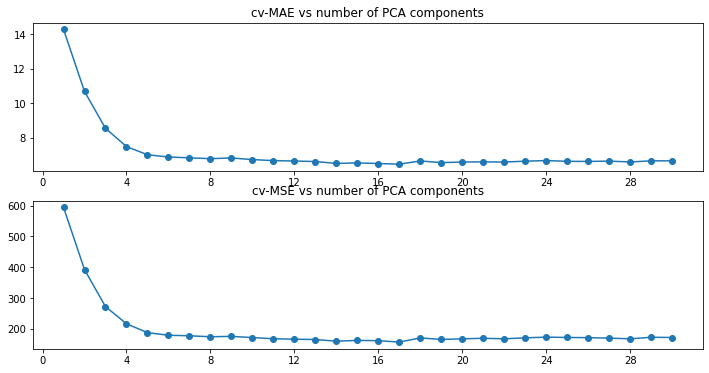

In [12]:
regressor = DecisionTreeRegressor()
cross_validation(regressor,x_train,y_train)

The best lowest cross-validation (MAE,MSE) point occurs when n=10 components which explain almost 90% of the total variance.
now we use another cross validation model to choose the best complexity parameter $\alpha$, but before let's take a look at the range of effective alpha finded by the regressor during the training time

In [13]:
pca = PCA(n_components = 10)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
regressor = DecisionTreeRegressor(random_state=0)
path = regressor.cost_complexity_pruning_path(x_train_pca, y_train)
ccp_alphas=path.ccp_alphas
pd.DataFrame(ccp_alphas).describe()

,0
count,1.240500e+04
mean,8.747198e-02
std,5.670892e+00
min,-9.505743e-17
25%,8.535396e-06
50%,1.382212e-04
75%,2.000006e-03
max,6.225977e+02


as we see there is a huge number of values, this means that the tree is very deep and prone to overfitting. Obviously we can not gridsearch them all, but we will select some values( far enough from the extremities ) and look after the best that gives sufficient performance on the test set

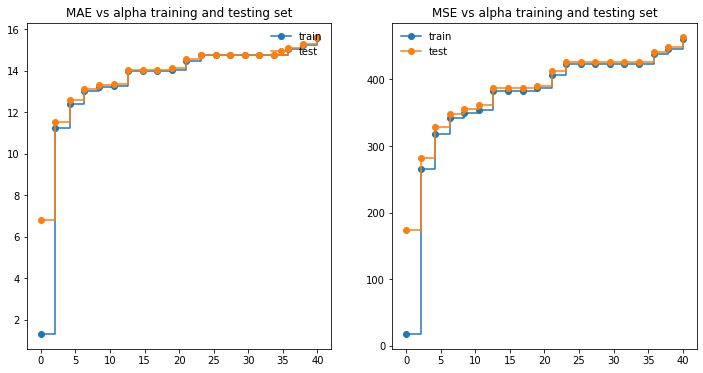

In [14]:
pca = PCA(n_components = 10)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
regressor = DecisionTreeRegressor()
alpha = np.linspace(0, 40, 20)
mae_train=[]
mae_val=[]
mse_train=[]
mse_val=[]
for a in alpha:
    regressor = DecisionTreeRegressor(ccp_alpha=a)
    scores = cross_validate(regressor, x_train_pca,y_train, scoring=("neg_mean_squared_error", "neg_mean_absolute_error"),return_train_score=True ,cv=10)
    mse_train.append(-scores['train_neg_mean_squared_error'].mean())
    mse_val.append(-scores['test_neg_mean_squared_error'].mean())
    mae_train.append(-scores['train_neg_mean_absolute_error'].mean())
    mae_val.append(-scores['test_neg_mean_absolute_error'].mean())
   
 

    
    # plot mae and mse
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(alpha,mae_train , label='train',marker='o',drawstyle="steps-post")
ax1.plot(alpha,mae_val, label='test',marker='o',drawstyle="steps-post")
ax1.title.set_text('MAE vs alpha training and testing set')
ax1.legend(loc="upper right", frameon=False)
ax2.plot(alpha, mse_train,label='train',marker='o',drawstyle="steps-post")
ax2.plot(alpha, mse_val,label='test',marker='o',drawstyle="steps-post")
ax2.title.set_text('MSE vs alpha training and testing set')
ax2.legend(frameon=False)
    

From the graph above , the best alpha value that minimizes both train and test error is 0

In [15]:
pca = PCA(n_components = 10)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
regressor = DecisionTreeRegressor(ccp_alpha=0) 
regressor.fit(x_train_pca,y_train)
#predict the test data
y_pred = regressor.predict(x_test_pca)


In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("mae score = ",mae)
print("mse score = ",mse)

mae score =  6.328261761071952
mse score =  146.35106791068546


## random forest regressor 

for the random forest regressor, there exist a considerable number of hyperparameters must be set by the user before training, this includes the number of decision trees in the forest and the number of features considered by each tree when splitting a node. to find out the probably best value candidates, we'll conduct the gridsearch technique, the results will then be used to fit the model on the whole trainnig set.

these are the parameters we're trying to adjust:
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* bootstrap = method for sampling data points (with or without replacement)

In [17]:
model = RandomForestRegressor()

#candidate values of hyperparameters
parameters = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 300, 500,700]}
grid = GridSearchCV(model, parameters, cv=3, n_jobs=-1)
grid.fit(x_train_pca, y_train.ravel())
print('Best depth:',grid.best_estimator_.max_depth) 
print('Best number of features:',grid.best_estimator_.max_features)
print('Best number of trees:',grid.best_estimator_.n_estimators)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best depth: 90
Best number of features: 3
Best number of trees: 700


In [18]:
#Random Forest regressor
model=RandomForestRegressor(n_estimators=500,bootstrap=True,random_state=21,verbose=0,max_depth=100,max_features=3)
model.fit(x_train_pca,y_train.ravel())
y_pred = model.predict(x_test_pca)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("mae score = ",mae)
print("mse score = ",mse)

mae score =  5.725258304192619
mse score =  99.42535238540003


As expected ,the randomforest shows better performance, than simple tree, the main cause is that the decision tree is more prone to overfit, however the randomforest aggregate many decision trees to limit overfitting as well as error due to bias and therefore yield great results.